# Word Prediction using Recurrent Neural Networks (RNNs)
## Experiment 2016-12-23

Loop over training size, plot learning curves. 

### Table of Contents

1. Prepare Data
2. Explore Data
3. Train Models
4. Test Models
5. Generate Text

## Imports

In [130]:
# import python modules
from __future__ import print_function, division
import os.path
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from nltk import tokenize

In [131]:
# import wp modules (can be slow)
import sys; sys.path.append('../../src')
print('importing wp (and nltk)...')
import wp
print('done')

importing wp (and nltk)...
done


In [132]:
# reload wp modules in case changed (for development purposes)
reload(wp)
reload(wp.data)
reload(wp.util)
reload(wp.model)
reload(wp.ngram)
reload(wp.rnn)
reload(wp.analyze)

<module 'wp.analyze' from '../../src\wp\analyze.pyc'>

## Initialize

In [133]:
random.seed(0)

## 1. Prepare Data

Merge raw text files, convert to plain strings, split into train, validate, and test sets.

In [134]:
# get wrapper around all data and tokenization
data = wp.data.Data()

Merge the raw data files into one and remove non-ascii characters (nltk complains otherwise).

In [135]:
data.merge()

The raw files have already been merged.


Split the merged file by sentences into train, validate, and test sets.

In [136]:
data.split()

The merged file has already been split.


## 2. Explore Data

### Show some samples of the text

In [137]:
s_merged = data.text('merged')
nsamples = 4
nchars = len(s_merged)
nskip = int(nchars / nsamples)
for i in range(nsamples):
    s = s_merged[i*nskip:i*nskip+200]
    s = s.replace('\n', ' ').strip()
    print(s)
    print()

The Project Gutenberg EBook of Les Misrables, by Victor Hugo  This eBook is for the use of anyone anywhere at no cost and with almost no restrictions whatsoever. You may copy it, give it away or re-us

ng his loss of sleep by an hour at the swimming-school, he mounted rapidly to his chamber, took merely time enough to throw off his travelling-coat, and the black ribbon which he wore round his neck,

than Javert. Javert, after his unlooked-for escape from the barricade, had betaken himself to the prefecture of police, had rendered a verbal account to the Prefect in person in a brief audience, had

hire, where, some six months before, he had been left an orphan. Now, owing to the generous offer of his elderly cousin, Mr Abney, he had come to live at Aswarby. The offer was unexpected, because all



### Show some text split into sentences

This shows how the text was split up into the train, validate, and test sets.

In [138]:
# we'll just look at the first 50k characters, because parsing sentences is slow
sentences = data.sentences('merged', 50000)
random.seed(2)
samples = random.sample(sentences, 5)
print('\n\n'.join(samples))

He said, _"En b!

In the winter they break this bread up with an axe, and they soak it for twenty-four hours, in order to render it eatable.

No one could have told: all that was known was, that when he returned from Italy he was a priest.

No one would have dared to mention them; no one would have dared to recall them.

Mon Dieu!


### Show the text split into tokens

Note that punctuation marks are treated as separate tokens.

In [139]:
tokens = data.tokens('merged', 50000)
print('ntokens',len(tokens))
print(tokens[-50:])

ntokens 10556
['he', 'saw', 'everyone', 'exclaiming', 'very', 'loudly', ',', 'and', 'growing', 'angry', 'very', 'quickly', ',', '``', 'Oh', '!', 'END', 'oh', '!', "''", 'END', 'he', 'said', ',', 'with', 'a', 'smile', ';', '``', 'to', 'all', 'appearance', ',', 'this', 'is', 'a', 'great', 'crime', 'which', 'all', 'the', 'world', 'commits', '.', 'END', 'These', 'are', 'hypocrisies', 'w', 'END']


## 3. Train Models

Train models on the training tokens.

In [140]:
# define models to train and test
model_specs = [
    [wp.ngram.NgramModel, {'n':1}],
    [wp.ngram.NgramModel, {'n':2}],
    [wp.ngram.NgramModel, {'n':3}],
    [wp.ngram.NgramModel, {'n':4}],
    [wp.rnn.RnnModel, {'nvocabmax':1000,'nhidden':10}],
]

In [156]:
# train models on different amounts of training data

nchars_list = (1000,10000,100000,1000000,6000000)
model_folder = '../../data/models'
model_table = wp.analyze.init_model_table(model_specs, model_folder, data, nchars_list)

ntraining_chars 1000
loaded model n-gram (n=1)
loaded model n-gram (n=2)
loaded model n-gram (n=3)
loaded model n-gram (n=4)
loaded model rnn
ntraining_chars 10000
loaded model n-gram (n=1)
loaded model n-gram (n=2)
loaded model n-gram (n=3)
loaded model n-gram (n=4)
loaded model rnn
ntraining_chars 100000
loaded model n-gram (n=1)
loaded model n-gram (n=2)
loaded model n-gram (n=3)
loaded model n-gram (n=4)
loaded model rnn


## 4. Test Models

Test all models on held-out test data.

In [152]:
# test all models and save results to a pandas dataframe

ntest_chars = 10000
npredictions_max = 1000
k = 3 # predict top k tokens

df = wp.analyze.test_model_table(model_table, data, ntest_chars, npredictions_max, k)

get complete stream of test tokens, nchars=10000
n-gram (n=1): accuracy = nright/total = 173/1001 = 0.172827
n-gram (n=2): accuracy = nright/total = 5/1001 = 0.004995
n-gram (n=3): accuracy = nright/total = 0/1001 = 0.000000
n-gram (n=4): accuracy = nright/total = 0/1001 = 0.000000
rnn: accuracy = nright/total = 16/1001 = 0.015984
get complete stream of test tokens, nchars=10000
n-gram (n=1): accuracy = nright/total = 173/1001 = 0.172827
n-gram (n=2): accuracy = nright/total = 16/1001 = 0.015984
n-gram (n=3): accuracy = nright/total = 2/1001 = 0.001998
n-gram (n=4): accuracy = nright/total = 0/1001 = 0.000000
rnn: accuracy = nright/total = 71/1001 = 0.070929
get complete stream of test tokens, nchars=10000
n-gram (n=1): accuracy = nright/total = 92/1001 = 0.091908
n-gram (n=2): accuracy = nright/total = 31/1001 = 0.030969
n-gram (n=3): accuracy = nright/total = 8/1001 = 0.007992
n-gram (n=4): accuracy = nright/total = 1/1001 = 0.000999
rnn: accuracy = nright/total = 34/1001 = 0.033966


In [153]:
df

,1000,10000,100000
n-gram (n=1),0.172827,0.172827,0.091908
n-gram (n=2),0.004995,0.015984,0.030969
n-gram (n=3),0.000000,0.001998,0.007992
n-gram (n=4),0.000000,0.000000,0.000999
rnn,0.015984,0.070929,0.033966


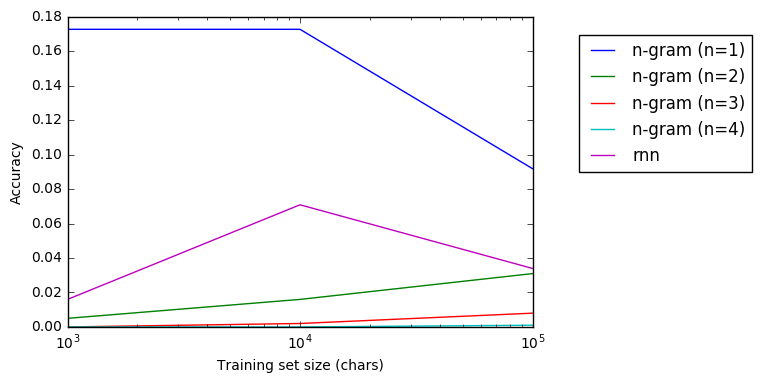

In [154]:
for i in range(len(df.index)):
    ix_i = df.ix[i]
    plt.plot(df.columns, ix_i)
plt.legend(loc=(1.1,0.5))
plt.xscale('log')
plt.xlabel('Training set size (chars)')
plt.ylabel('Accuracy')
plt.show()

## 5. Generate Text

In [155]:
nsentences = 5
models = model_table[-1] # use models with most training data
for model in models[1:]:
    print(model.name)
    print('-'*80)
    for seed in range(nsentences):
        random.seed(seed)
        tokens = model.generate()
        if tokens:
            s = ' '.join(tokens)
            print(s)
            print()
    print()

n-gram (n=1)
--------------------------------------------------------------------------------
CHAPTER be END

They out by has I and door accuse , me CHAPTER that by under and him the . etc Linnus must of . END

. . , , CHAPTER SATISFIED a time to to hospitals been that END

the of END

the , END


n-gram (n=2)
--------------------------------------------------------------------------------
Carrier is another wolf . END

For the innocent , nevertheless , and sick and four unfortunate gendarmes were set to any one of a paper , and the treasurer of renunciation and set to whom his arrival , Poinot , 1833 CHAPTER VI -- THE CONJUNCTION OF SERVICE FROM THE SEWER AND NICOLETTE CHAPTER IV -- fifteen hundred francs , and forty-six thousand francs , because he was afraid ? END

As he had discovered these thousand francs each other without , naked to notice it my carriage in with absolute submission by him , `` I shall see of all , common enough to it happen that valley , which were a schoolboy .